In [406]:
import pyarrow
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, regularizers
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential, load_model

from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [407]:
data = pd.read_parquet('FEData_For_Modelling.parquet').reset_index(drop = True)
data

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810


In [408]:
import os
malicious_filenames = os.listdir('answers/r5.2-2')
malicious_users = []

for filename in malicious_filenames:
    malicious_users.append(filename.replace('r5.2-2-', "").replace('.csv', ""))

malicious_users

['MDS0680',
 'GWG0497',
 'CKP0630',
 'HMS1658',
 'BYO1846',
 'HXP0976',
 'CIF1430',
 'ITA0159',
 'OSS1463',
 'SNK1280',
 'HIS1394',
 'SIS0042',
 'HSN0675',
 'MCP0611',
 'TNB1616',
 'CHP1711',
 'MGB1235',
 'NAH1366',
 'JAL0811',
 'OKM1092',
 'TMT0851',
 'DCC1119',
 'KSS1005',
 'VCF1602',
 'RRS0056',
 'WDT1634',
 'ICB1354',
 'ZIE0741',
 'LVF1626',
 'TRC1838']

In [530]:
data['malicious'] = np.where(data['user'].isin(malicious_users), 1, 0)
data

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,0
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,0
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,0
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,0
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,0
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,0
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,0
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810,0


In [531]:
from collections import Counter

X = data.drop(columns = ['user', 'malicious'])
y = data.malicious

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

print("Train Labels before Resampling")
print(Counter(y_train))

Train Labels before Resampling
Counter({0: 1574, 1: 26})


### now using
X_train, X_test

y_train, y_test

In [532]:
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE(sampling_strategy=0.8) #sampling_strategy=0.8
resampled_X_train, resampled_y_train = oversample.fit_resample(X_train, y_train)

print("Train Labels after Resampling")
print(Counter(resampled_y_train))

Train Labels after Resampling
Counter({0: 1574, 1: 1259})


### now using

resample_X_train, X_test

resampled_y_train, y_test

^^ before standardisation

In [583]:
# Standardize features, scaled already
scaler = StandardScaler() #MinMaxScaler()
data_scaled = scaler.fit(resampled_X_train)
resampled_X_train = data_scaled.transform(resampled_X_train)
X_test = data_scaled.transform(X_test)

### now using

resampled_X_train, X_test

resampled_y_train, y_test

^^ after standardisation

In [648]:
train_labels = resampled_y_train.astype(bool)
test_labels = y_test.astype(bool)

normal_train_data = resampled_X_train[train_labels]
normal_test_data = X_test[test_labels]

anomalous_train_data = resampled_X_train[~train_labels]
anomalous_test_data = X_test[~test_labels]


In [585]:
# normal_train_data.shape

## autoencoder architecture

In [649]:
nb_epoch = 65
batch_size = 512
input_dim = resampled_X_train.shape[1] #num of columns, 17
encoding_dim = 256
hidden_dim1 = 128 
hidden_dim2 = 64
hidden_dim3 = 32
#learning_rate = 0.001
learning_rate = 1e-5

In [650]:
# This returns a tensor
input_layer = Input(shape=(input_dim, ))

# a layer instance is callable on a tensor, and returns a tensor
# Dense implements the operation: output = activation(dot(input, kernel) + bias), where
# activation is the element-wise activation function passed as the activation argument, 
# kernel is a weights matrix created by the layer, and 
# bias is a bias vector created by the layer (only applicable if use_bias is True).

# activity_regularizer: Regularizer function applied to the output of the layer
encoder = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l2(learning_rate)
                )(input_layer)
encoder = Dense(hidden_dim1, activation="relu")(encoder)
encoder = Dense(hidden_dim2, activation="relu")(encoder)
encoder = Dense(hidden_dim3, activation="relu")(encoder)
decoder = Dense(hidden_dim3, activation='relu')(encoder)
decoder = Dense(hidden_dim2, activation='relu')(encoder)
decoder = Dense(hidden_dim1, activation='relu')(decoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

# This creates a model that includes
# the Input layer and four Dense layers
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [651]:
# Configure the learning process, by compiling the model
autoencoder.compile(optimizer='adam',
                    metrics=['acc', 'mse'],
                    loss='mean_squared_error')

In [652]:
autoencoder.summary()

Model: "functional_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_53 (InputLayer)     │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_395 (Dense)               │ (None, 256)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_396 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_397 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_398 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_400 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_401 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_402 (Dense)               │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,465 (236.19 KB)

 Trainable params: 60,465 (236.19 KB)

 Non-trainable params: 0 (0.00 B)

In [653]:
# Starts training
# autoencoder: same training(x) and target data(y)
# validation_data: tuple (x_val, y_val) on which 
# to evaluate the loss and any model metrics at the end of each epoch.

# History.history attribute is a record of training loss values 
# and metrics values at successive epochs.
history = autoencoder.fit(x=resampled_X_train, y=resampled_X_train,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test, X_test)
                          )

Epoch 1/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - acc: 0.0941 - loss: 1.3563 - mse: 1.2730 - val_acc: 0.1425 - val_loss: 1.5662 - val_mse: 1.4895
Epoch 2/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.0775 - loss: 1.2931 - mse: 1.2216 - val_acc: 0.1650 - val_loss: 1.4983 - val_mse: 1.4302
Epoch 3/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.0915 - loss: 1.2383 - mse: 1.1741 - val_acc: 0.1600 - val_loss: 1.3837 - val_mse: 1.3211
Epoch 4/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.1101 - loss: 1.0969 - mse: 1.0399 - val_acc: 0.1750 - val_loss: 1.2757 - val_mse: 1.2161
Epoch 5/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.1105 - loss: 0.9239 - mse: 0.8691 - val_acc: 0.1775 - val_loss: 1.1969 - val_mse: 1.1396
Epoch 6/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.1561 - loss: 0.9803 - mse: 0.9247 - val_acc: 0.2150 - val_loss: 1.1561 - val_mse: 1.1016
Epoch 7/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.1803 - loss: 0.8285 - mse: 0.7791 - val_acc: 0.2625 - val_lo

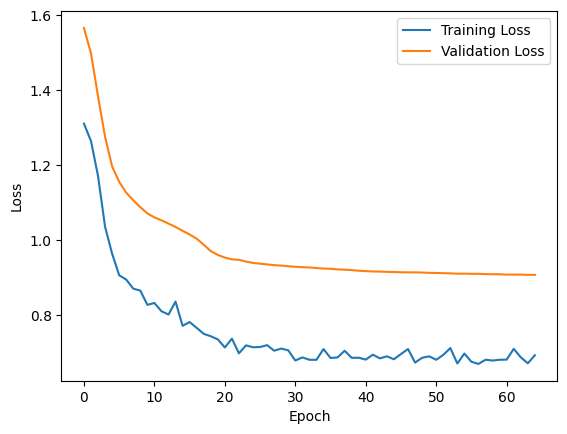

In [654]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## analysis

In [655]:
test_x_predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
error_df.describe()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


,Reconstruction_error,True_class
count,400.000000,400.000000
mean,0.903975,0.010000
std,2.554273,0.099623
min,0.058918,0.000000
25%,0.209753,0.000000
50%,0.334941,0.000000
75%,0.601833,0.000000
max,28.005474,1.000000


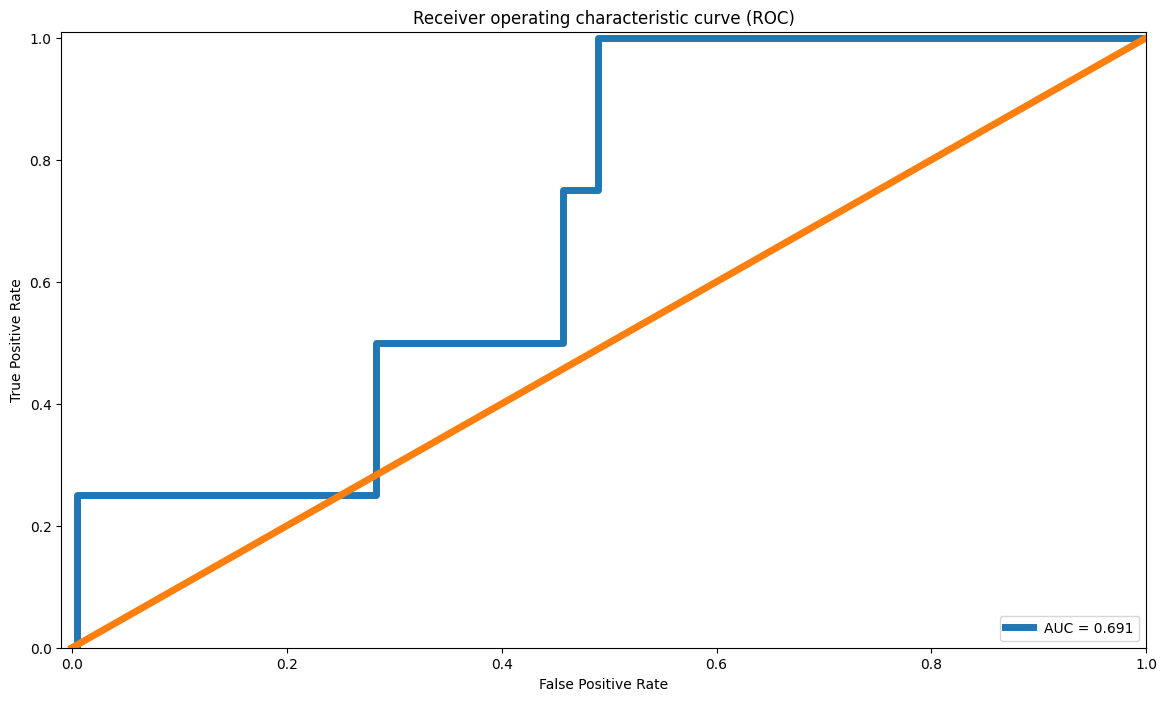

In [656]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.figure(figsize=(14, 8))
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

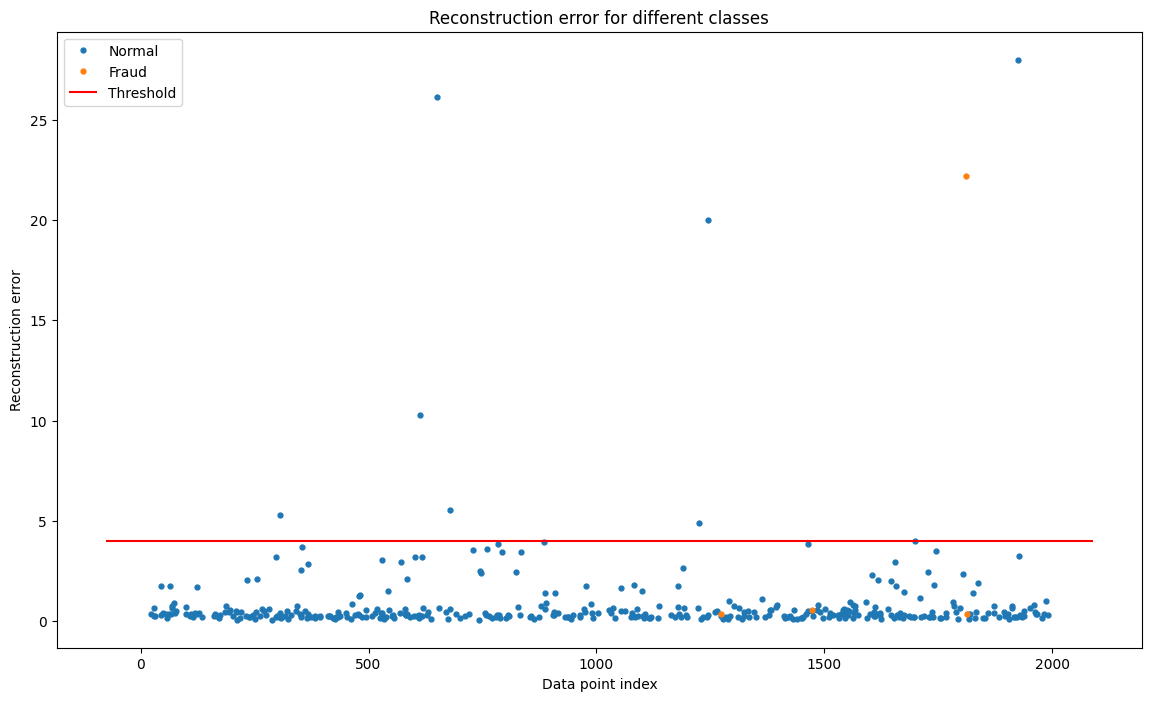

In [657]:
threshold_fixed = 4
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(14, 8))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1],
          colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


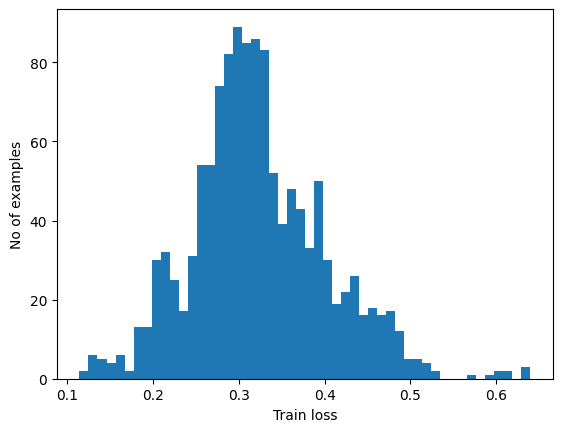

In [659]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [660]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.4017124808416719


In [661]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mse(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  disp = ConfusionMatrixDisplay(confusion_matrix=(confusion_matrix(labels, predictions)))
  disp.plot()
  plt.title("Confusion matrix")
  plt.ylabel('True class')
  plt.xlabel('Predicted class')
  plt.show()
  print("\nClassification Report:\n", classification_report(labels, predictions))
  print("Accuracy = {:.2f}%".format(accuracy_score(labels, predictions)*100))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))
  print("f-1 score = {}".format(f1_score(labels, predictions)))

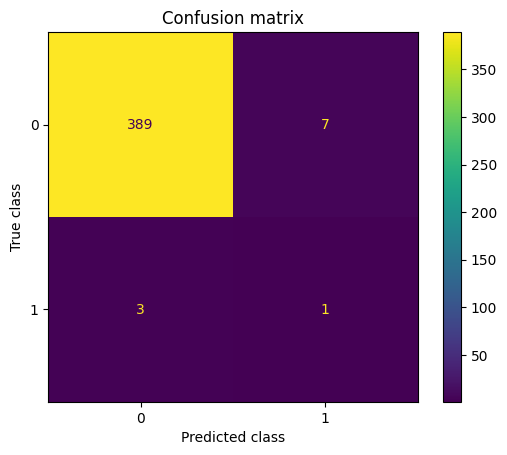


Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.98      0.99       396
        True       0.12      0.25      0.17         4

    accuracy                           0.97       400
   macro avg       0.56      0.62      0.58       400
weighted avg       0.98      0.97      0.98       400

Accuracy = 97.50%
Precision = 0.125
Recall = 0.25
f-1 score = 0.16666666666666666


In [666]:
# As with autoencoders, it is the assumption that fraud or anomalies will suffer 
# from a detectably high reconstruction error, predicting class as 1 (Fraud)
# if reconstruction error is greater than threshold
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

print_stats(pred_y, test_labels)
